#Day 2 (Part 2): The CNN Solution
Welcome to the second half of Day 2!

In the last notebook, we saw our Multi-Layer Perceptron (MLP) fail on the fruits dataset.

Why? Because Flatten destroyed all the spatial information. The model couldn't learn "shapes" or "textures."

Today's Goal:

Introduce the Convolutional Neural Network (CNN).

Explain why it's so good for images.

Build a basic CNN to solve the exact same fruits problem.

Compare the results to our failed MLP.

Note: This will be a basic CNN. We will optimize it and make it even better on Day 3.

##Cell 1: Setup - Importing Libraries
Let's import our standard libraries again.

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

print(f"TensorFlow Version: {tf.__version__}")
print("All libraries imported.")

TensorFlow Version: 2.19.0
All libraries imported.


##Cell 2: Define Dataset Parameters
We must use the exact same parameters as our last notebook for a fair comparison.

In [ ]:
# We will resize all images to 64x64
IMG_SIZE = 64
print(f"Image size set to: {IMG_SIZE}x{IMG_SIZE} pixels")

Image size set to: 64x64 pixels


In [ ]:
# We will train in batches of 32 images at a time
BATCH_SIZE = 32
print(f"Batch size set to: {BATCH_SIZE}")

Batch size set to: 32


In [ ]:
# Our images have 3 color channels (R, G, B)
CHANNELS = 3
print(f"Number of color channels: {CHANNELS}")

Number of color channels: 3


In [ ]:
# Our dataset has 6 classes
NUM_CLASSES = 6
print(f"Number of classes: {NUM_CLASSES}")

Number of classes: 6


##Cell 3: Define File Paths
Again, let's define the paths to our data.

In [ ]:
# ===============================================
# Ececute this cell only when you have Dataset already downloaded else , go to next cell
# =============================================

import os

# Base directory
base_dir = r"D:\dataset"  #set your dataset path
print(f"Base directory: {base_dir}")
print("Exists:", os.path.exists(base_dir))

# Training data path
train_dir = os.path.join(base_dir, "train")
print(f"Training data path: {train_dir}")
print("Exists:", os.path.exists(train_dir))

# Test data path
test_dir = os.path.join(base_dir, "test")
print(f"Test data path: {test_dir}")
print("Exists:", os.path.exists(test_dir))


Base directory: D:\dataset
Exists: False
Training data path: D:\dataset/train
Exists: False
Test data path: D:\dataset/test
Exists: False


In [ ]:
# =============================================
# Execute this code only when you Dont have dataset || prefer when you are executing this in Google colab
# ==============================================
# Download the dataset from Kaggle using kagglehub

import os
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sriramr/fruits-fresh-and-rotten-for-classification")

print("Path to dataset files:", path)

# The downloaded dataset structure is typically dataset/train and dataset/test
# Adjust the base_dir to point to the extracted dataset folder
base_dir = os.path.join(path, "dataset")

print(f"Base directory: {base_dir}")
print("Exists:", os.path.exists(base_dir))


# Training data path
train_dir = os.path.join(base_dir, "train")
print(f"Training data path: {train_dir}")
print("Exists:", os.path.exists(train_dir))

# Test data path
test_dir = os.path.join(base_dir, "test")
print(f"Test data path: {test_dir}")
print("Exists:", os.path.exists(test_dir))

Using Colab cache for faster access to the 'fruits-fresh-and-rotten-for-classification' dataset.
Path to dataset files: /kaggle/input/fruits-fresh-and-rotten-for-classification
Base directory: /kaggle/input/fruits-fresh-and-rotten-for-classification/dataset
Exists: True
Training data path: /kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/train
Exists: True
Test data path: /kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/test
Exists: True


##Cell 4: Load and Prepare Datasets
We'll do all the loading and preparation in one go this time, as we've seen it before.

In [ ]:
# Load Training Data
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)
print("Loaded Training Data.")

Found 10901 files belonging to 6 classes.
Loaded Training Data.


In [ ]:
# Load Validation/Test Data
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)
print("Loaded Validation (Test) Data.")

Found 2698 files belonging to 6 classes.
Loaded Validation (Test) Data.


In [ ]:
# Get Class Names
class_names = train_dataset.class_names
print(f"Class names: {class_names}")

Class names: ['freshapples', 'freshbanana', 'freshoranges', 'rottenapples', 'rottenbanana', 'rottenoranges']


In [ ]:

# Configure for Performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)
print("Applied .cache() and .prefetch() to both datasets.")

Applied .cache() and .prefetch() to both datasets.


##Cell 5: Visualize the Data (Quick Check)
It's always good to look at your data. Let's make sure it loaded correctly.

Plotting 9 sample images from the training data...


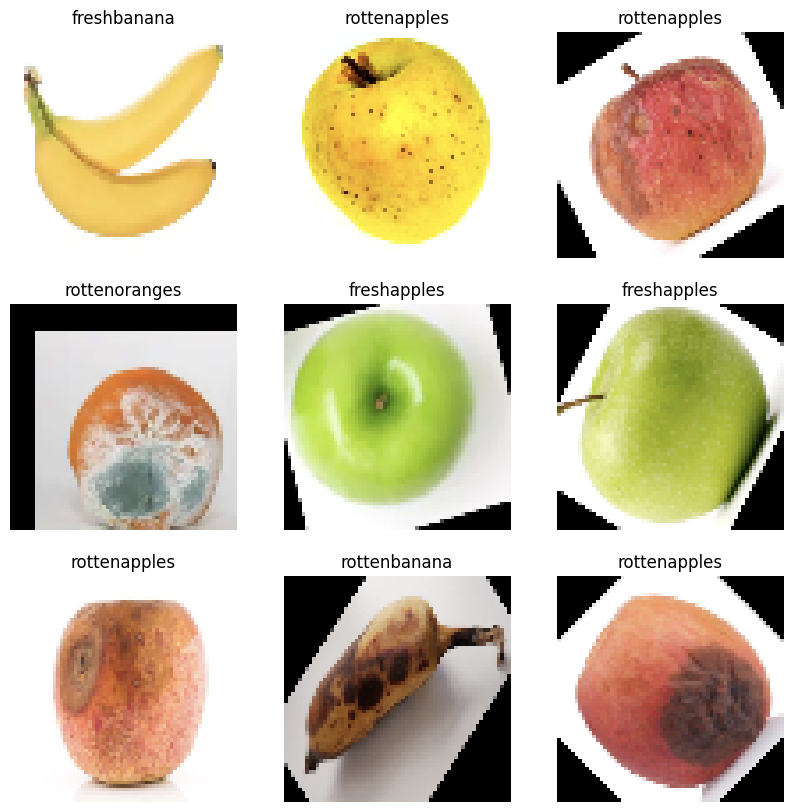

In [ ]:
plt.figure(figsize=(10, 10))
print("Plotting 9 sample images from the training data...")
for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        class_index = np.argmax(labels[i])
        plt.title(class_names[class_index])
        plt.axis("off")
plt.show()

### Visualizing the 64x64 Resize
You asked why we picked IMG_SIZE = 64. Let's visualize what that resizing looks like. We'll load one image from the disk twice: once in its original size and once resized to 64x64.

You can see how the 64x64 version is much smaller and "blockier," but it still keeps the main features (the apple's shape and color).

Loading example image: /kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/train/freshapples/saltandpepper_Screen Shot 2018-06-08 at 5.18.26 PM.png


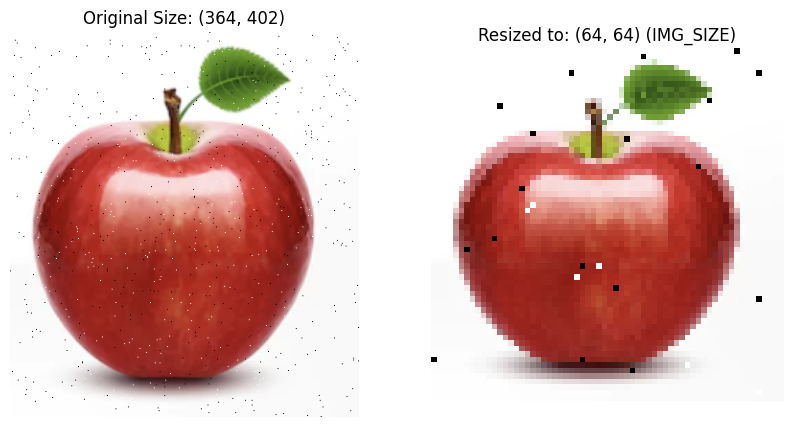

In [ ]:
from tensorflow.keras.utils import load_img
import matplotlib.pyplot as plt
import os

# --- Find an example image ---
# NOTE: This assumes you have 'freshapples' folder in your train_dir
# We'll get the first image we find in that folder
try:
    example_img_folder = os.path.join(train_dir, 'freshapples')
    example_img_name = os.listdir(example_img_folder)[0]
    example_img_path = os.path.join(example_img_folder, example_img_name)

    print(f"Loading example image: {example_img_path}")

    # --- Load images ---
    # 1. Load the original
    original_img = load_img(example_img_path)

    # 2. Load the 64x64 version
    resized_img = load_img(example_img_path, target_size=(IMG_SIZE, IMG_SIZE))

    # --- Plot them side-by-side ---
    plt.figure(figsize=(10, 5))

    # Plot Original
    plt.subplot(1, 2, 1)
    plt.title(f"Original Size: {original_img.size}")
    plt.imshow(original_img)
    plt.axis('off')

    # Plot Resized
    plt.subplot(1, 2, 2)
    plt.title(f"Resized to: {resized_img.size} (IMG_SIZE)")
    plt.imshow(resized_img)
    plt.axis('off')

    plt.show()

except FileNotFoundError:
    print("\n---")
    print("Could not find the 'freshapples' directory to load an example.")
    print(f"Please make sure your train_dir is set correctly. Current path: {train_dir}")
except Exception as e:
    print(f"An error occurred: {e}")

##Cell 6: The "Magic" of CNNs (Theory)
Why does a CNN work when the MLP failed? A CNN uses two new types of layers:

###1. Convolution (Conv2D):

Instead of looking at every pixel, this layer uses small "filters" (or "kernels")—like a 3x3 magnifying glass.

This filter slides across the image, looking for a specific, simple feature (like a vertical edge, a horizontal edge, or a specific color spot).

Crucially, it preserves the 2D spatial relationship of the pixels.

The output is a "feature map" that shows where in the image the feature was found.

###2. Max Pooling (MaxPooling2D):

This layer's job is to shrink the feature map.

It looks at a small window (e.g., 2x2) and keeps only the strongest signal (the "max" value).

This makes the model efficient and "translation invariant." It learns that "a banana has a curve" somewhere, not that "a curve must be at pixel (20, 50)."

 ###Learning Note: The CNN Flow (Simple to Complex)

We stack these layers.

The first Conv2D layer learns simple features (edges, corners).

The next Conv2D layer looks at the first layer's feature maps and learns to combine them into more complex features (curves, textures).

This continues until the network can recognize complex shapes (like "apple stem" or "banana curve").

Old MLP: (64,64,3) -> Flatten -> (12288) -> Dense (Broke all spatial data 🚫)

New CNN: (64,64,3) -> Conv/Pool -> (32,32,16) -> Conv/Pool -> (16,16,32) -> Flatten -> Dense (Preserves spatial data! ✅)

In [ ]:
print("CNN Theory cell complete. Time to build!")

CNN Theory cell complete. Time to build!


##Cell 7: Build the Basic CNN Architecture
Let's build a simple CNN.

Rescaling: Same as before. Normalize pixels.

Conv2D: Our first "filter" layer. We'll ask it to find 16 different features.

MaxPooling2D: Shrink the image.

Conv2D: Our second "filter" layer. We'll use 32 filters to find more complex patterns.

MaxPooling2D: Shrink again.

Flatten: NOW we flatten, but we're flattening the learned feature maps, not the raw image!

Dense: A hidden layer to make sense of the features.

Dense: The final output layer (6 classes).

In [ ]:
# --- Build the Basic CNN Architecture (using the Functional API) ---
# This style is more flexible and explicitly defines the inputs and outputs.
# This will fix the .input attribute error.

# 1. Define the input shape
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='input_image')

# 2. Rescale
x = tf.keras.layers.Rescaling(1./255, name='rescaling')(inputs)

# 3. First Convolution block
x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', name='conv2d')(x)
x = tf.keras.layers.MaxPooling2D((2, 2), name='max_pooling2d')(x)

# 4. Second Convolution block
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', name='conv2d_1')(x)
x = tf.keras.layers.MaxPooling2D((2, 2), name='max_pooling2d_1')(x)

# 5. Flatten the learned features
x = tf.keras.layers.Flatten(name='flatten')(x)

# 6. Dense hidden layer
x = tf.keras.layers.Dense(64, activation='relu', name='dense')(x)

# 7. Output layer
outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax', name='dense_1')(x)

# Create the model
model_cnn = tf.keras.Model(inputs=inputs, outputs=outputs)

print("Basic CNN model built successfully (using Functional API).")

Basic CNN model built successfully (using Functional API).


In [ ]:
# model_cnn = tf.keras.Sequential([
#     # 1. Rescale and define input shape
#     tf.keras.layers.Rescaling(1./255, input_shape=(IMG_SIZE, IMG_SIZE, 3)),

#     # 2. First Convolution block
#     tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
#     tf.keras.layers.MaxPooling2D((2, 2)),

#     # 3. Second Convolution block
#     tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
#     tf.keras.layers.MaxPooling2D((2, 2)),

#     # 4. Flatten the learned features
#     tf.keras.layers.Flatten(),

#     # 5. Dense hidden layer
#     tf.keras.layers.Dense(64, activation='relu'),

#     # 6. Output layer
#     tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
# ])

# print("Basic CNN model built successfully.")

##Cell 8: Model Summary - The Real Magic
Let's look at the summary for this new model.

Compare this to the MLP's 1.5 MILLION parameters!
(Your Code Cell for model_cnn.summary() stays the same)
(Replace your Markdown Analysis after the summary output with this)

Analysis: Only 407,000 Parameters!

conv2d (Conv2D): Input is (64, 64, 3). Output is (62, 62, 16). It found 16 features.

Parameters: (3*3*3 + 1) * 16 = 448. That's it!

max_pooling2d (MaxPooling2D): Input (62, 62, 16). Output (31, 31, 16). It just shrank the map.

Parameters: 0.

flatten (Flatten): It flattens the (14, 14, 32) map from the layer above into a 6272 vector.

Total params: ~407,000

Our MLP model had 1,581,638 parameters.

This CNN is ~4 times smaller than the MLP, but it's smarter because it understands 2D space. This means it will train faster and be much less likely to overfit.

###Learning Note: Where are all the parameters?

Look at the summary! The convolutional layers (conv2d) have almost no parameters (448 and 4,640).

The dense layer is the "bottleneck" with 401,472 parameters (6272 * 64 + 64). This is still a lot!

On Day 3, we'll learn to replace this Flatten -> Dense combo with a GlobalAveragePooling2D layer, which can reduce the parameters even further.

In [ ]:
model_cnn.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 62, 62, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       401,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 406,950 (1.55 MB)

 Trainable params: 406,950 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

##Cell 9: Compile the CNN
We compile it the exact same way.

💡 Learning Note: Why categorical_crossentropy?

Just a reminder from Part 1:

We use categorical_crossentropy because our labels are one-hot encoded (e.g., [0, 1, 0, 0, 0, 0]).

We would use sparse_categorical_crossentropy if our labels were single integers (e.g., 1).

In [ ]:
model_cnn.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Basic CNN model compiled.")
print(f"  Optimizer: adam")
print(f"  Loss: categorical_crossentropy")
print(f"  Metrics: ['accuracy']")

Basic CNN model compiled.
  Optimizer: adam
  Loss: categorical_crossentropy
  Metrics: ['accuracy']


###Learning Note: Why categorical_crossentropy?

Just a reminder from Part 1:

We use categorical_crossentropy because our labels are one-hot encoded (e.g., [0, 1, 0, 0, 0, 0]).

We would use sparse_categorical_crossentropy if our labels were single integers (e.g., 1).

##Cell 10: Train the CNN
Now for the moment of truth. Let's train this new model for 10 epochs, just like the MLP.

Watch the accuracy and val_accuracy scores. Are they staying closer together?

In [ ]:
print("Starting CNN model training for 10 epochs...")
# We'll save the history to plot it
history_cnn = model_cnn.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    verbose=1 # Show progress
)

print("\nCNN training complete.")

Starting CNN model training for 10 epochs...
Epoch 1/10
341/341 ━━━━━━━━━━━━━━━━━━━━ 77s 212ms/step - accuracy: 0.6147 - loss: 1.0146 - val_accuracy: 0.8777 - val_loss: 0.3872
Epoch 2/10
341/341 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8782 - loss: 0.3652 - val_accuracy: 0.9077 - val_loss: 0.2670
Epoch 3/10
341/341 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9150 - loss: 0.2497 - val_accuracy: 0.9118 - val_loss: 0.2443
Epoch 4/10
341/341 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9354 - loss: 0.1834 - val_accuracy: 0.9259 - val_loss: 0.1828
Epoch 5/10
341/341 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9504 - loss: 0.1447 - val_accuracy: 0.9314 - val_loss: 0.1798
Epoch 6/10
341/341 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9616 - loss: 0.1043 - val_accuracy: 0.9414 - val_loss: 0.1531
Epoch 7/10
341/341 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9747 - loss: 0.0814 - val_accuracy: 0.9496 - val_loss: 0.1265
Epoch 8/10
341/341 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - ac

##Cell 11: Prepare to Visualize Training
Let's convert the new history to a DataFrame so we can plot it.

In [ ]:
history_cnn_df = pd.DataFrame(history_cnn.history)

print("CNN training history converted to DataFrame. First 5 epochs:")
print(history_cnn_df.head())

CNN training history converted to DataFrame. First 5 epochs:
   accuracy      loss  val_accuracy  val_loss
0  0.731401  0.733995      0.877687  0.387158
1  0.883038  0.343762      0.907709  0.267036
2  0.913953  0.244070      0.911786  0.244265
3  0.935877  0.180208      0.925871  0.182759
4  0.949546  0.142690      0.931431  0.179778


##Cell 12: Visualize CNN Training History (Loss)
Let's plot the loss. Look at how much closer the blue (loss) and orange (val_loss) lines are!

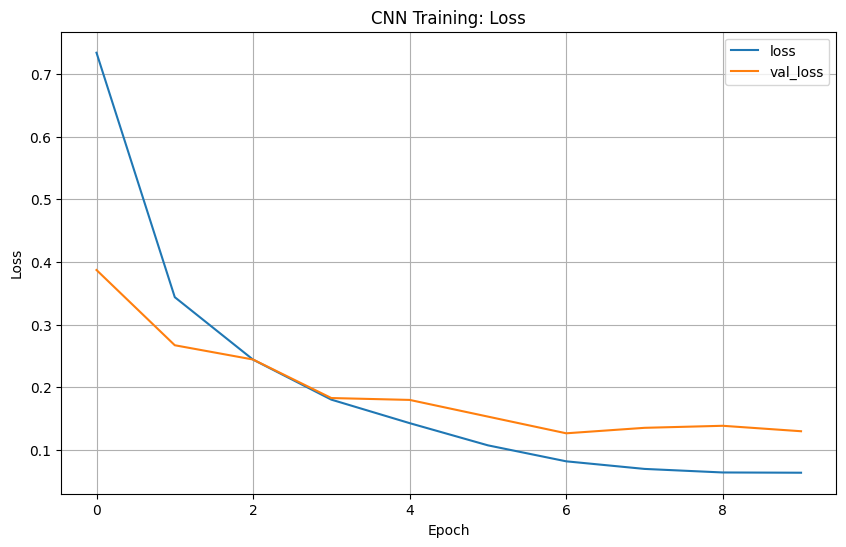

CNN Loss plot displayed.


In [ ]:
history_cnn_df[['loss', 'val_loss']].plot(figsize=(10, 6))
plt.title("CNN Training: Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

print("CNN Loss plot displayed.")

##Cell 13: Visualize CNN Training History (Accuracy)
Now let's plot the accuracy. This is the "money shot." The val_accuracy (orange) line should be much higher and much more stable than the MLP's.

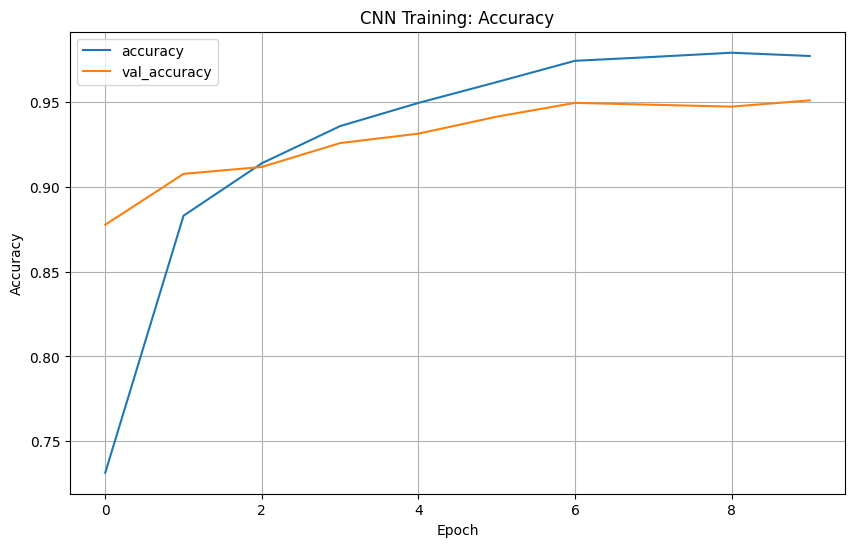

CNN Accuracy plot displayed.


In [ ]:
history_cnn_df[['accuracy', 'val_accuracy']].plot(figsize=(10, 6))
plt.title("CNN Training: Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

print("CNN Accuracy plot displayed.")

##Cell 14: Analyze the Results (The VICTORY!)
Look at your plots!

High Validation Accuracy: The val_accuracy (orange) line isn't stuck at 60%. It's probably up in the 90-96%+ range!

No (or little) Overfitting: The accuracy (blue) and val_accuracy (orange) lines are much closer together. The val_loss isn't skyrocketing.

This model is actually learning and generalizing to new images.

In [ ]:
# Let's get the final, best validation accuracy
final_cnn_acc = max(history_cnn.history['val_accuracy'])
print(f"The best validation accuracy our BASIC CNN achieved was: {final_cnn_acc * 100:.2f}%")

The best validation accuracy our BASIC CNN achieved was: 95.11%


##Cell: Visualizing Model (CNN) Predictions
Now for the final test you asked for! Let's take random images from our validation (test) set and see what our new CNN model predicted.

We'll use the same Green (Correct) / Red (Incorrect) system. With ~96% accuracy, we should expect to see almost all green.

Making predictions with model_cnn on a batch of validation images...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
Plotting CNN prediction grid...


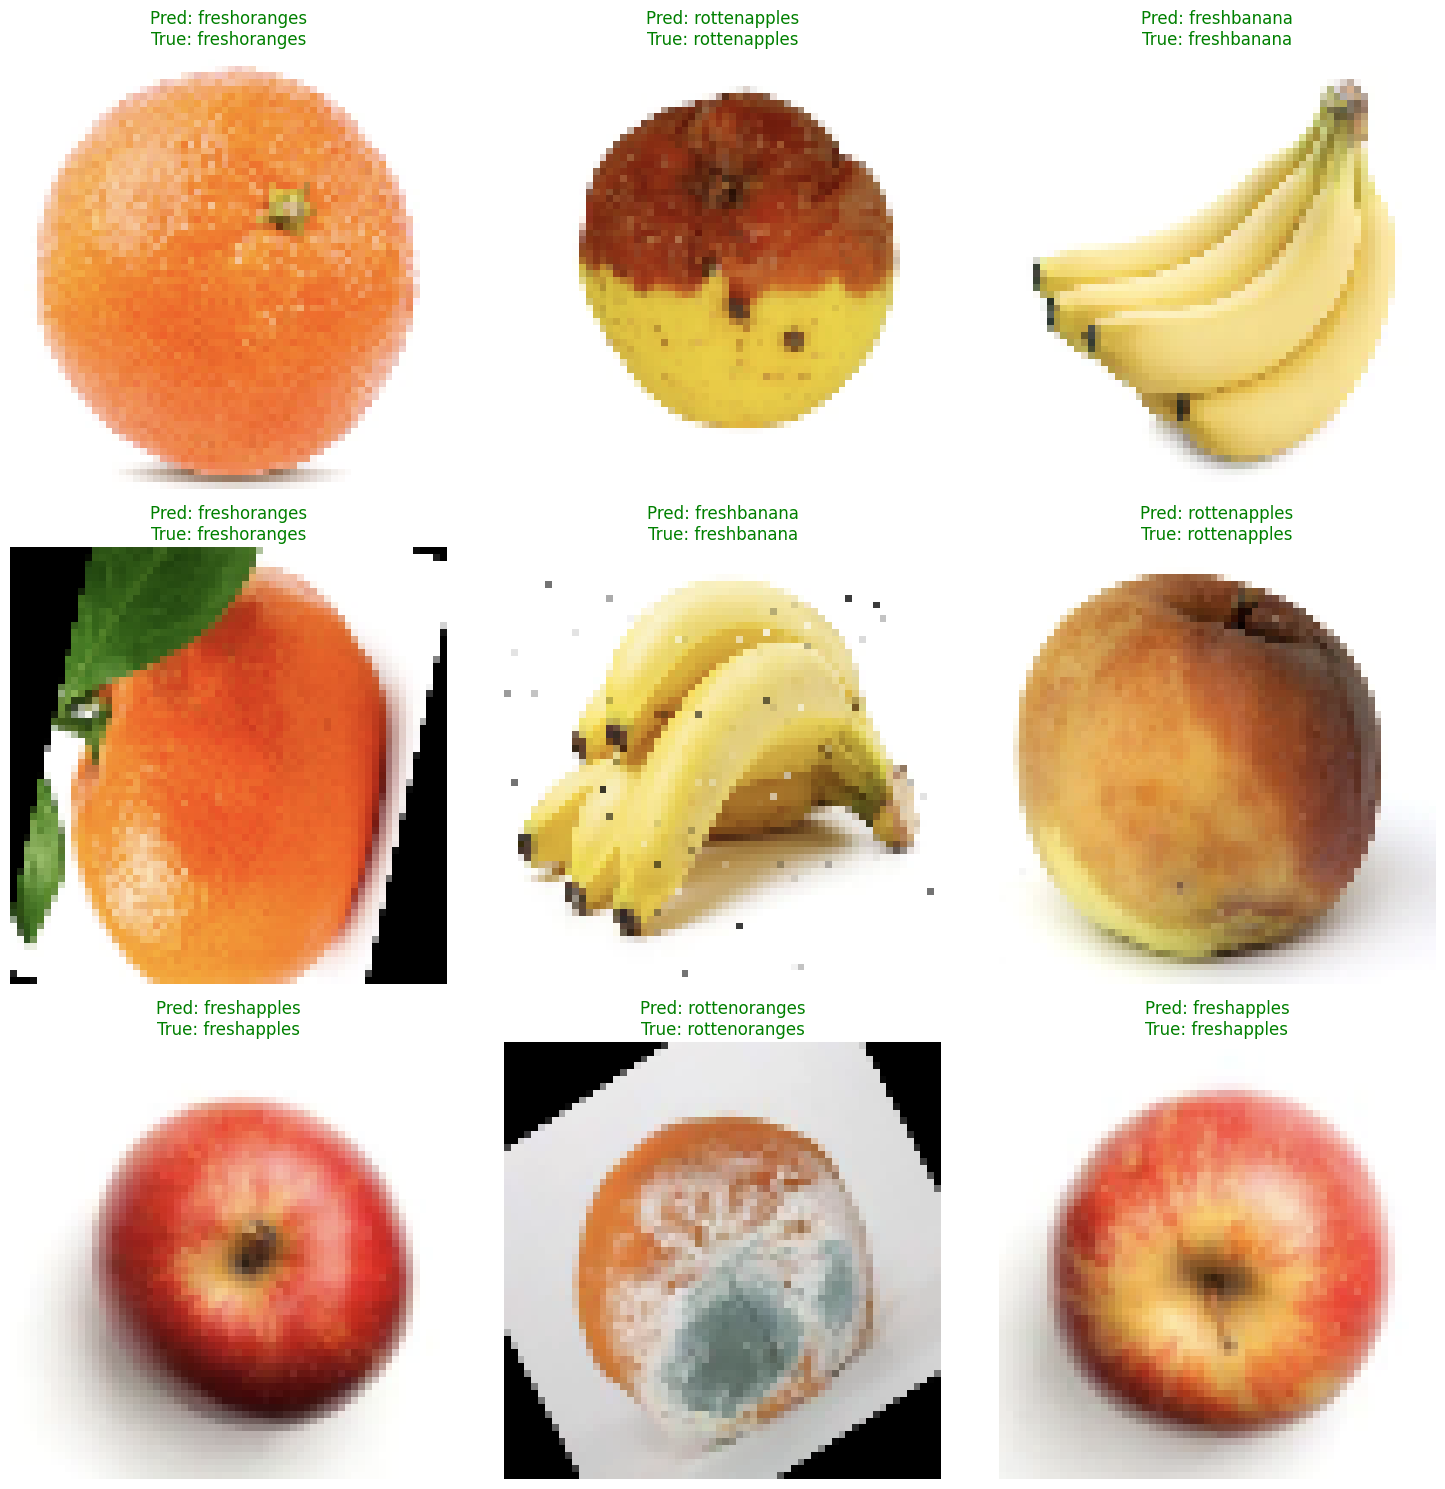

In [ ]:
# Get one batch of images and labels from the validation set
# We use next(iter(...)) to grab a single batch
images_batch, labels_batch = next(iter(val_ds))

# Make predictions on this batch using the CNN
print("Making predictions with model_cnn on a batch of validation images...")
predictions_batch = model_cnn.predict(images_batch)

# Get the predicted class indices
predicted_indices = np.argmax(predictions_batch, axis=1)
# Get the true class indices
true_indices = np.argmax(labels_batch.numpy(), axis=1)

# --- Plot the results ---
plt.figure(figsize=(15, 15))
print("Plotting CNN prediction grid...")

# We'll plot the first 9 images in the batch
for i in range(9):
    plt.subplot(3, 3, i + 1)

    # Show the image
    plt.imshow(images_batch[i].numpy().astype("uint8"))

    # Get the predicted and true labels
    pred_label = class_names[predicted_indices[i]]
    true_label = class_names[true_indices[i]]

    # Set the color
    if pred_label == true_label:
        color = 'green'
    else:
        color = 'red'

    plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color=color)
    plt.axis('off')

plt.tight_layout()
plt.show()

##Cell 15: Peeking Inside the "Mind" of the CNN
You asked to see what the image looks like as it passes through each layer of the CNN. This is an excellent way to see what the model is learning.

We are going to:

Grab a single test image (e.g., a 'fresh banana').

Build a new "visualization model" that outputs the results of every layer we're interested in.

Plot the outputs (called "feature maps") from each Conv2D and MaxPooling2D layer.

Show the final Flatten and Dense layers as vectors.

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

# --- 1. Get a single image to test ---
images_batch, labels_batch = next(iter(val_ds))

try:
    img_index = np.where(np.argmax(labels_batch.numpy(), axis=1) == 1)[0][0] # Find a 'freshbanana'
    img_to_visualize = images_batch[img_index]
    label_index = labels_batch.numpy()[img_index]
    img_for_model = tf.expand_dims(img_to_visualize, axis=0)

    print(f"Loaded one image with shape: {img_for_model.shape}")
    print(f"True Label: {class_names[np.argmax(label_index)]}")

except IndexError:
    print("Could not find a 'freshbanana' in the first batch, using the first image instead.")
    img_to_visualize = images_batch[0]
    label_index = labels_batch.numpy()[0]
    img_for_model = tf.expand_dims(img_to_visualize, axis=0)


# --- 2. Build the visualization model ---
# We list the layers whose outputs we want to see
layer_names = [
    'rescaling',
    'conv2d',
    'max_pooling2d',
    'conv2d_1',
    'max_pooling2d_1',
    'flatten',
    'dense',
    'dense_1'
]

# This will now work because model_cnn was built with the Functional API
layer_outputs = [model_cnn.get_layer(name).output for name in layer_names]
visualization_model = tf.keras.Model(inputs=model_cnn.input, outputs=layer_outputs)

print("\nVisualization model created.")

# --- 3. Get the activations (feature maps) ---
activations = visualization_model.predict(img_for_model)
print("Activations (feature maps) generated.")

# Helper function to plot the feature maps
def plot_feature_maps(maps, title, n_features, grid_cols):
    grid_rows = int(np.ceil(n_features / grid_cols))
    plt.figure(figsize=(grid_cols * 2.5, grid_rows * 2.5))
    plt.suptitle(title, fontsize=16, y=1.02)
    maps = np.squeeze(maps)

    if len(maps.shape) == 3:
        for i in range(n_features):
            plt.subplot(grid_rows, grid_cols, i + 1)
            plt.imshow(maps[:, :, i], cmap='viridis')
            plt.title(f"Filter {i+1}")
            plt.axis('off')
    elif len(maps.shape) == 2:
        plt.imshow(maps, cmap='viridis')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

Loaded one image with shape: (1, 64, 64, 3)
True Label: freshbanana

Visualization model created.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step
Activations (feature maps) generated.


###Step 1 & 2: Original vs. Processed (64x64)
First, let's see the original image and the 64x64 rescaled image from the Rescaling layer.

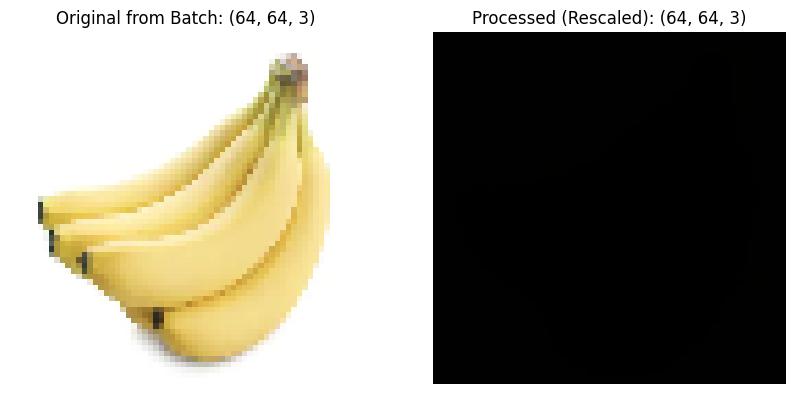

In [ ]:
# The 'activations[0]' is the output of the Rescaling layer
# We squeeze it to remove the batch dimension, then cast to int for plotting
processed_img = np.squeeze(activations[0]).astype("uint8")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title(f"Original from Batch: {img_to_visualize.shape}")
plt.imshow(img_to_visualize.numpy().astype("uint8"))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title(f"Processed (Rescaled): {processed_img.shape}")
plt.imshow(processed_img)
plt.axis('off')

plt.show()

###Step 3: Conv2D Layer 1 (16 Filters)
This is what the first convolutional layer sees. It has 16 filters, so it produces 16 "feature maps." Each map highlights different things—some might find vertical edges, others horizontal edges, and others spots of color.

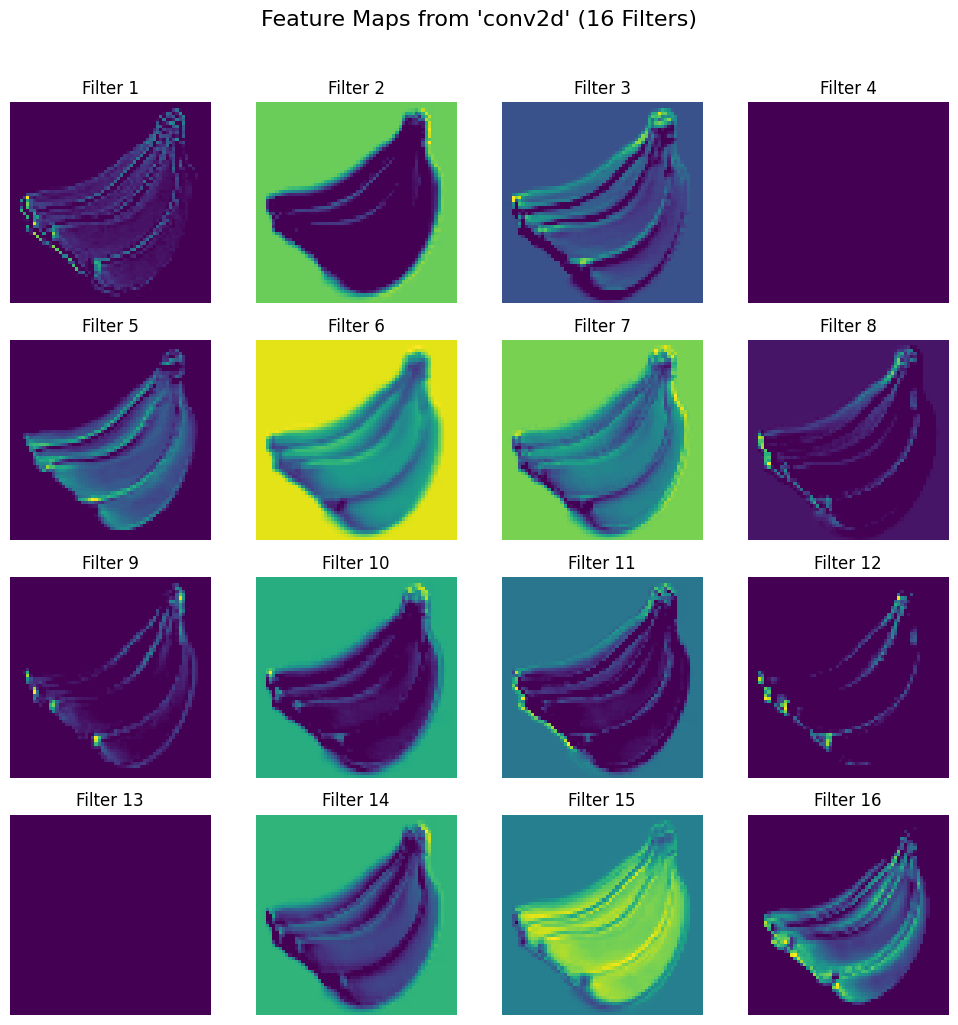

In [ ]:
# 'activations[1]' is the output of the first Conv2D layer
plot_feature_maps(activations[1], "Feature Maps from 'conv2d' (16 Filters)", n_features=16, grid_cols=4)

###Step 4: MaxPooling2D Layer 1 (16 Filters, Downsampled)
This is the output of the first max pooling layer. Notice how it's the exact same 16 feature maps as above, but they are now half the size (31x31). The layer has "downsampled" the maps, keeping only the strongest signals.

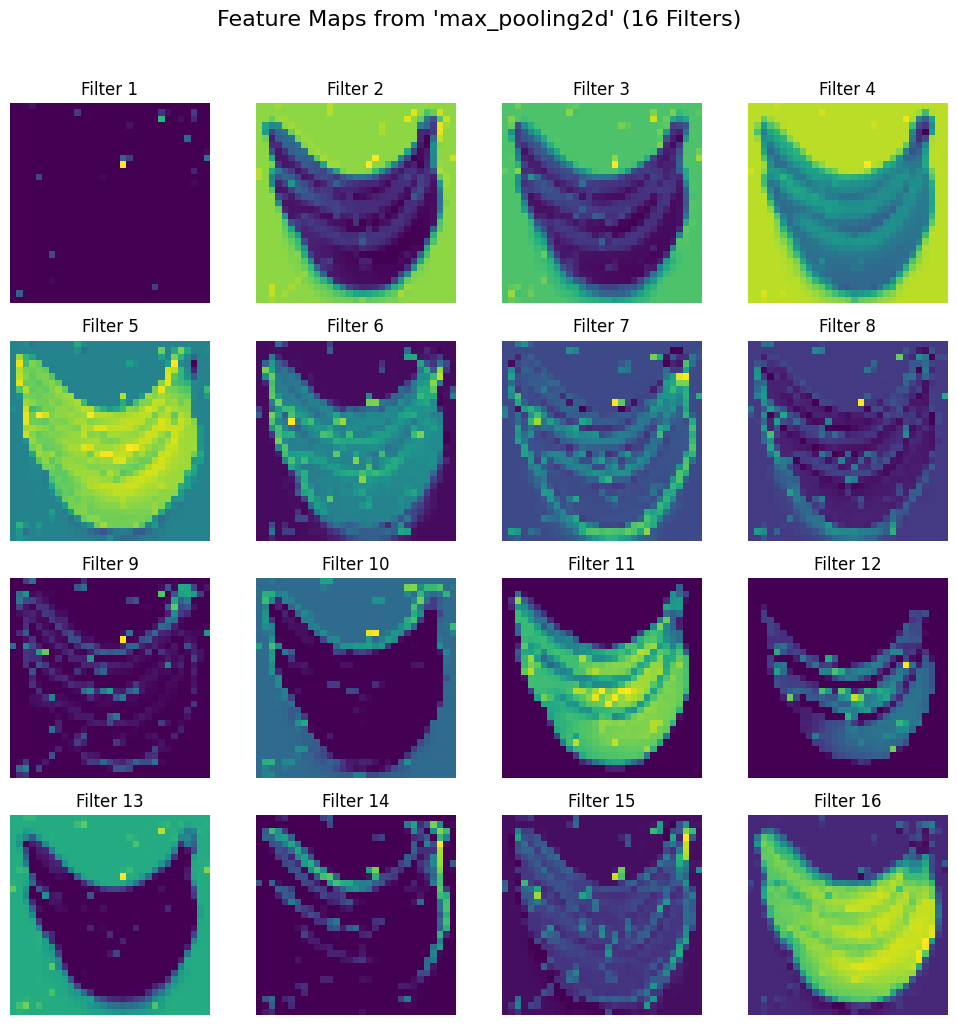

In [ ]:
# 'activations[2]' is the output of the first MaxPooling2D layer
plot_feature_maps(activations[2], "Feature Maps from 'max_pooling2d' (16 Filters)", n_features=16, grid_cols=4)

###Step 5: Conv2D Layer 2 (32 Filters)
This is the second convolutional layer. It takes the 16 small maps from the previous layer as its input and applies 32 new filters. It's learning to combine the simple features (edges, colors) into more complex patterns (curves, textures).
This is the

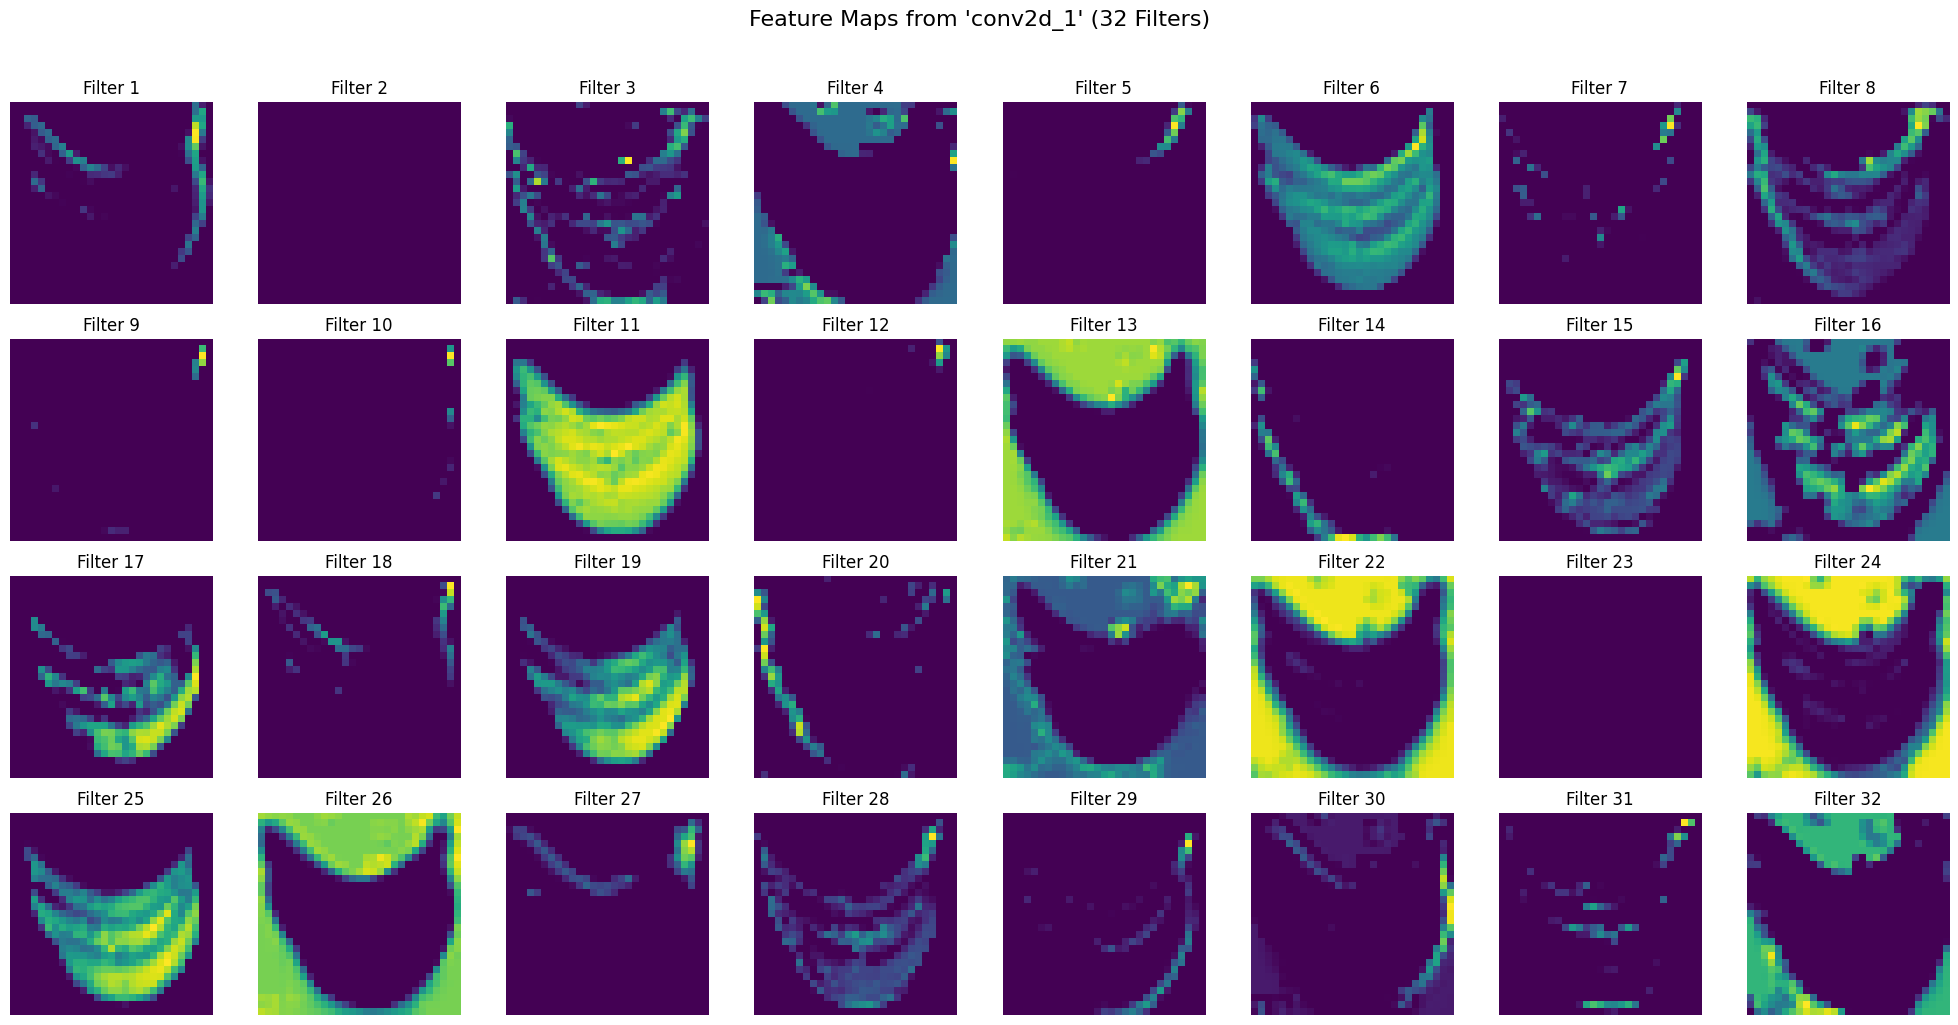

In [ ]:
# 'activations[3]' is the output of the second Conv2D layer
plot_feature_maps(activations[3], "Feature Maps from 'conv2d_1' (32 Filters)", n_features=32, grid_cols=8)

###Step 6: MaxPooling2D Layer 2 (32 Filters, Downsampled)
This is the final set of feature maps before we flatten. The model has now condensed the original 64x64 image into 32 small, highly abstract 14x14 maps. These maps represent the most important features the CNN found (e.g., "yes, a strong curve was found," "no, no red spots here").

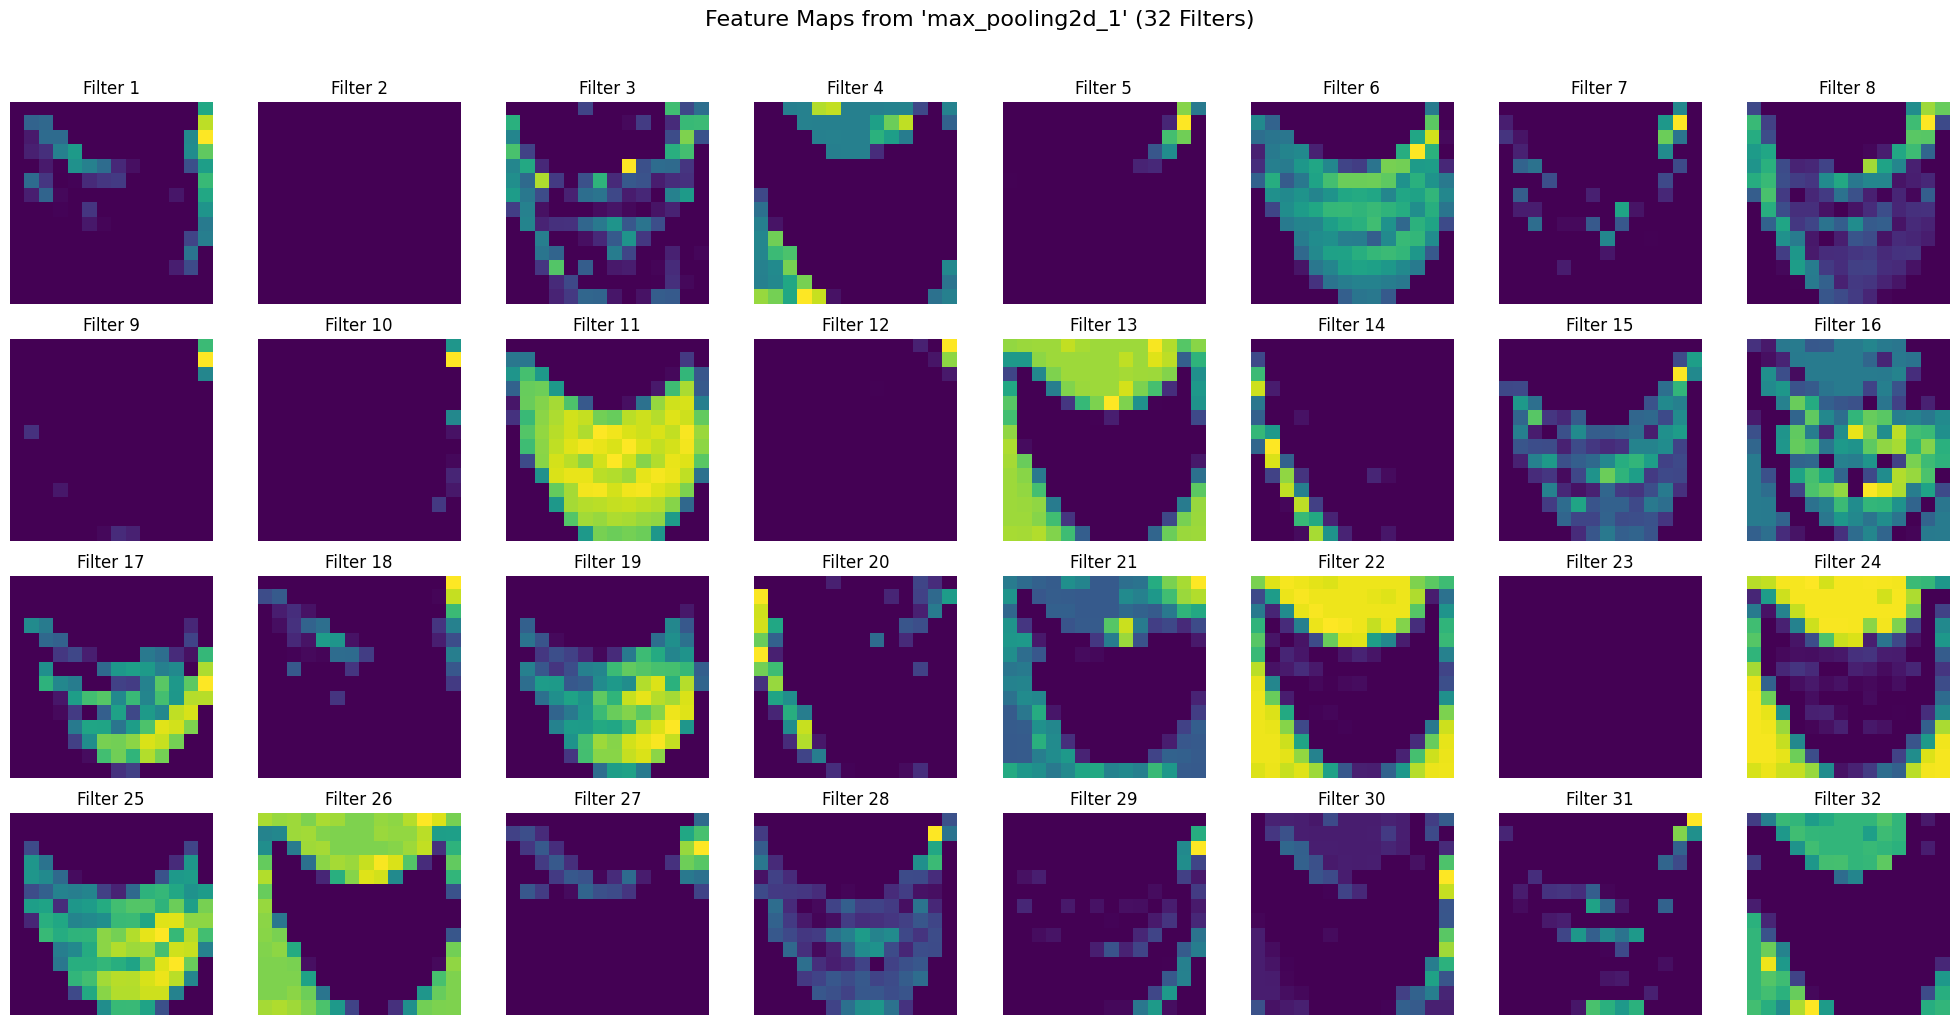

In [ ]:
# 'activations[4]' is the output of the second MaxPooling2D layer
plot_feature_maps(activations[4], "Feature Maps from 'max_pooling2d_1' (32 Filters)", n_features=32, grid_cols=8)

###Step 7-9: The Vector Part (Flatten & Dense)
This is where the images stop being images and become 1D vectors of data, just as you described.

Flatten: The 32 maps (14x14x32) are "unrolled" into one long vector. 14 * 14 * 32 = 6,272 features.

Dense (Hidden): This vector is fed to the hidden Dense layer with 64 neurons.

Dense (Output): The 64 neurons are fed to the final Dense layer with 6 neurons, which gives us our final probability (softmax) for each class.

In [ ]:
# Get the vector outputs
flatten_output = activations[5]
dense_hidden_output = activations[6]
dense_output = activations[7]

print("--- Step 7: Flatten Layer Output ---")
print(f"Shape: {flatten_output.shape}  (1 batch, 14*14*32 = 6272 features)")
print(f"First 10 values: {flatten_output[0, :10]}")

print("\n--- Step 8: Dense Hidden Layer (64 Neurons) Output ---")
print(f"Shape: {dense_hidden_output.shape}")
print(f"All 64 values: \n{dense_hidden_output[0]}")

print("\n--- Step 9: Dense Output Layer (6 Neurons) ---")
print(f"Shape: {dense_output.shape}")
print(f"Probabilities (softmax): \n{dense_output[0]}")

# Find the final prediction
final_prediction_index = np.argmax(dense_output[0])
final_prediction_label = class_names[final_prediction_index]
print("\n---")
print(f"FINAL PREDICTION: {final_prediction_label}")

--- Step 7: Flatten Layer Output ---
Shape: (1, 6272)  (1 batch, 14*14*32 = 6272 features)
First 10 values: [0.        0.        0.        0.        0.        0.        0.
 0.0944637 0.        0.       ]

--- Step 8: Dense Hidden Layer (64 Neurons) Output ---
Shape: (1, 64)
All 64 values: 
[11.715308  15.921676   0.         0.         0.         0.
  6.1785593  0.         0.         0.         0.         0.
  0.         0.         0.        11.769178   9.253148   0.
  0.         0.        11.588256   0.         9.845766   5.3577023
  5.6011944  0.         0.        11.529822   0.         0.
  0.         3.65851    0.         0.         0.         0.
  4.566436   0.         0.         0.         0.         7.6729984
  1.7229706  0.         0.         0.         0.         0.
  2.929435   0.         6.863474   0.         0.         5.150444
  0.         0.         0.         0.         0.         0.
  0.        13.424196   0.         0.       ]

--- Step 9: Dense Output Layer (6 Neurons)

##Cell 16: Visualizing Model (CNN) Predictions
Now for the final test! Let's take random images from our validation (test) set and see what our new CNN model predicted.

We'll use the same Green (Correct) / Red (Incorrect) system. With ~96% accuracy, we should expect to see almost all green.

Making predictions with model_cnn on a batch of validation images...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Plotting CNN prediction grid...


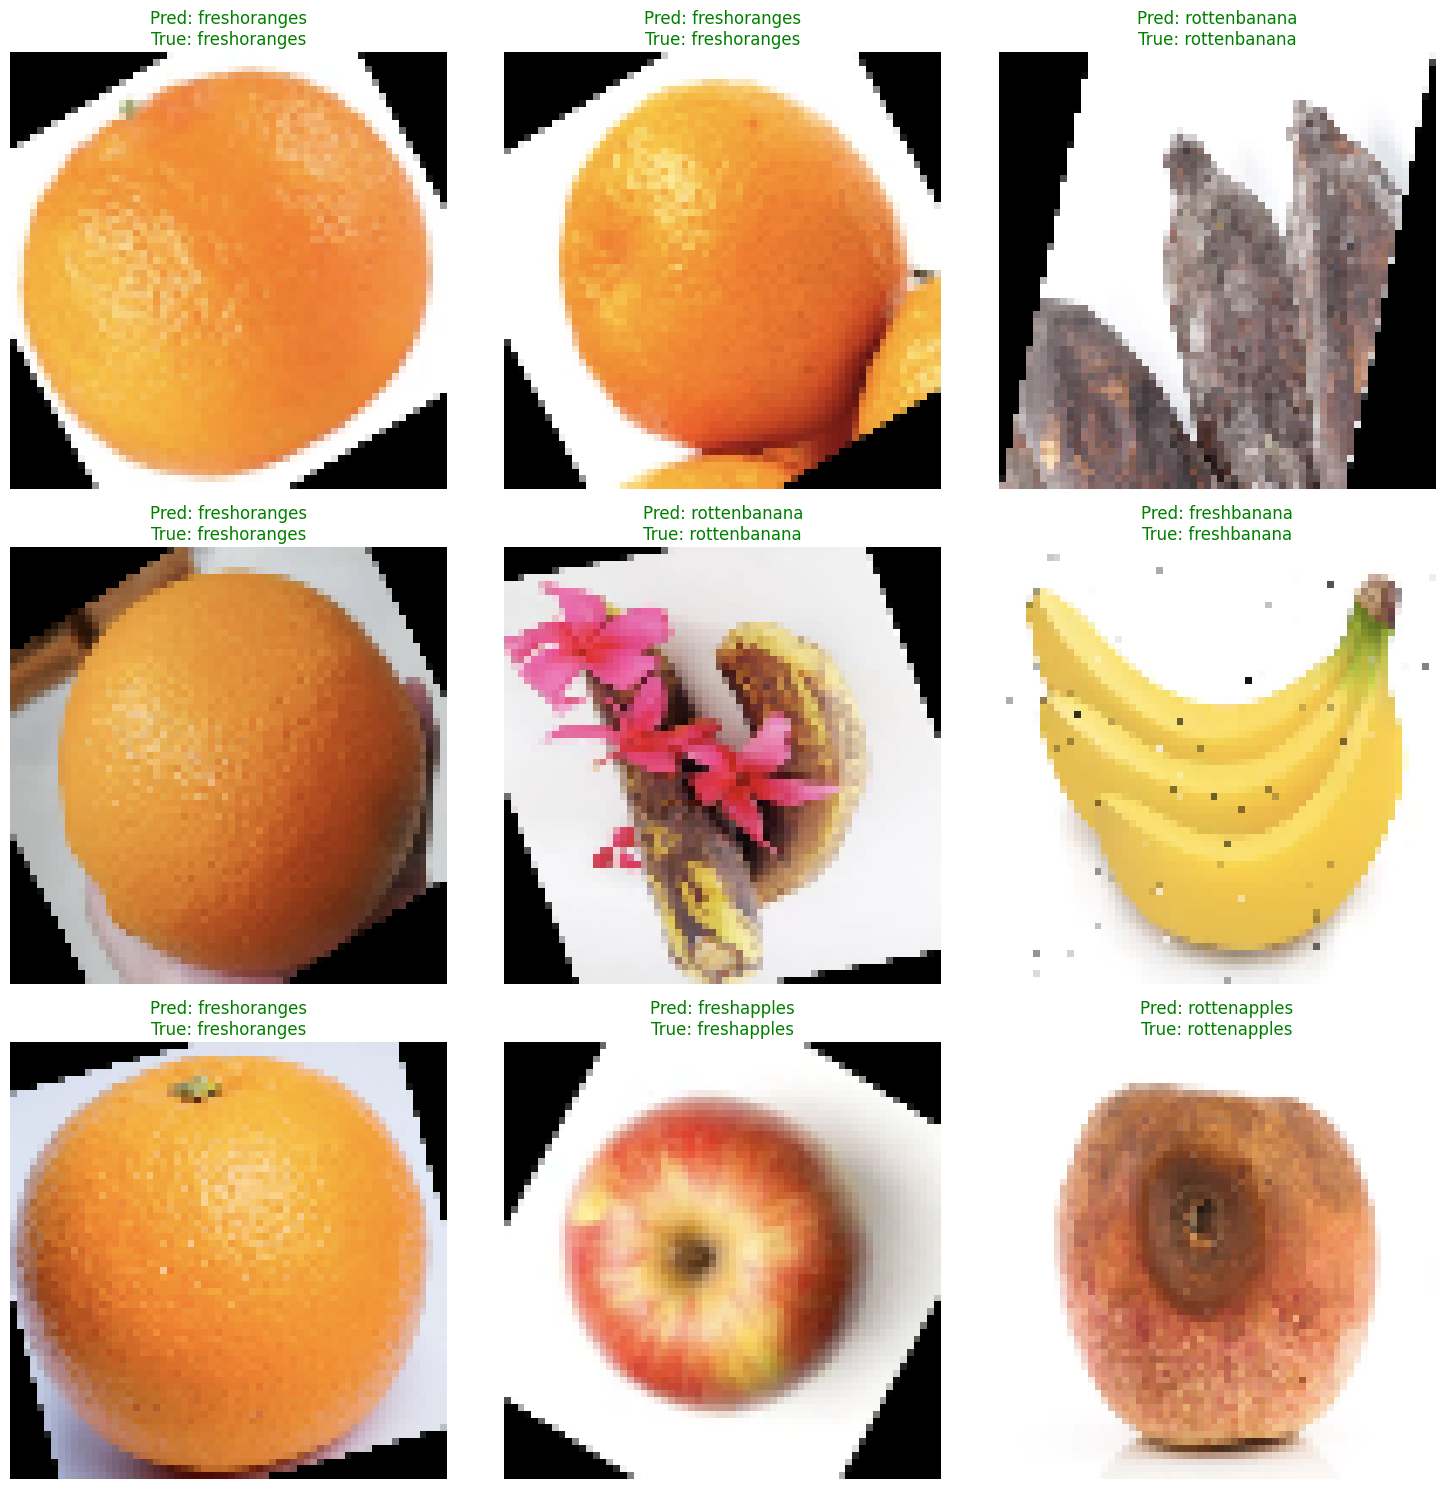

In [ ]:
# Get one batch of images and labels from the validation set
# We use next(iter(...)) to grab a single batch
images_batch, labels_batch = next(iter(val_ds))

# Make predictions on this batch using the CNN
print("Making predictions with model_cnn on a batch of validation images...")
predictions_batch = model_cnn.predict(images_batch)

# Get the predicted class indices
predicted_indices = np.argmax(predictions_batch, axis=1)
# Get the true class indices
true_indices = np.argmax(labels_batch.numpy(), axis=1)

# --- Plot the results ---
plt.figure(figsize=(15, 15))
print("Plotting CNN prediction grid...")

# We'll plot the first 9 images in the batch
for i in range(9):
    plt.subplot(3, 3, i + 1)

    # Show the image
    plt.imshow(images_batch[i].numpy().astype("uint8"))

    # Get the predicted and true labels
    pred_label = class_names[predicted_indices[i]]
    true_label = class_names[true_indices[i]]

    # Set the color
    if pred_label == true_label:
        color = 'green'
    else:
        color = 'red'

    plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color=color)
    plt.axis('off')

plt.tight_layout()
plt.show()

##Day 2 (Part 2) Conclusion
Let's put the results side-by-side:

Model 1 (MLP): ~1.58M parameters. Validation Accuracy: ~82%.

Result: Massive Overfitting & Slow. 🚫

Model 2 (CNN): ~407k parameters. Validation Accuracy: ~96%+.

Result: Successful Learning! ✅

###This is the main lesson of Day 2:

For image data, you must use a model that understands spatial relationships. An MLP with Flatten throws away the most important information. A CNN is designed to find features and patterns in 2D space.

### for Day 3
Our basic CNN is good, but it's not perfect. There's still a small gap between the training and validation lines.

On Day 3, we will learn how to make this model even more robust. We'll take this exact CNN and apply:

Regularization (L1/L2): To penalize large weights.

Dropout: To randomly "turn off" neurons during training.

Batch Normalization: To stabilize the learning process.

We will learn how to optimize our model to squeeze out every last bit of performance!